In [1]:
#Imports
import pandas as pd
import googlemaps
import numpy as np
import pprint
import time
from scipy import stats
import random
import datetime
from pymongo import MongoClient
import matplotlib.pyplot as plt
from IPython.display import clear_output

_______________________________________________________
# Import Relevant Information from US Dept Energy
____________________________________________________________

In [2]:
#Read in Energy Dept Info on Electric Car Recharging Stations
recharge_station_data = pd.read_csv('CSV Files/alt_fuel_stations (Oct 23 2020).csv')

/home/louisbove84/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6,16,20,33,39,40,41,43,49,55,57,58,60,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Show all data obtained from US Department of Energy 
#recharge_station_data.info()

In [4]:
#Only include electric charging stations in the DataFrame
station_db = recharge_station_data[recharge_station_data['Fuel Type Code']=='ELEC']

#Remove Canada from DataFrame
station_db = station_db[station_db['Country']=='US']

#Drop irrelevant columns
station_db = station_db.iloc[:, [1,2,4,5,6,18,19,21,24,25,32,37,47,54]]

#Convert Lat-Long data into a readable format for Google API
station_db['Latitude'] = station_db['Latitude'].astype(str)
station_db['Longitude'] = station_db['Longitude'].astype(str) 
station_db['lat_long'] = station_db['Latitude'] + ',' + station_db['Longitude']

#Merge Station Name, Street Address, City, and State code for Google API
station_db['full_address'] = station_db['Station Name'] + ' ' + station_db['Street Address'] + ' ' + station_db['City'] + ' ' + station_db['State']

#Create 'Open Datetime' column converted from non-datatime column 'Open Date' 
station_db['Open Datetime'] = pd.to_datetime(station_db['Open Date'].str.replace('-',''))

#Replace 'Tesla Destination' string with 'Tesla'
station_db['EV Network'] = station_db['EV Network'].replace(['Tesla Destination'],'Tesla')

In [5]:
#View all info from the corrected dataframe
#station_db.info()
#station_db[station_db['Facility Type']=='HOTEL'].info()
#station_db['EV Pricing'].value_counts().head(5)

______________________________________________________
# Exploratory Data Analysis
_________________________________________________

## 1. Charging Stations by State

No handles with labels found to put in legend.


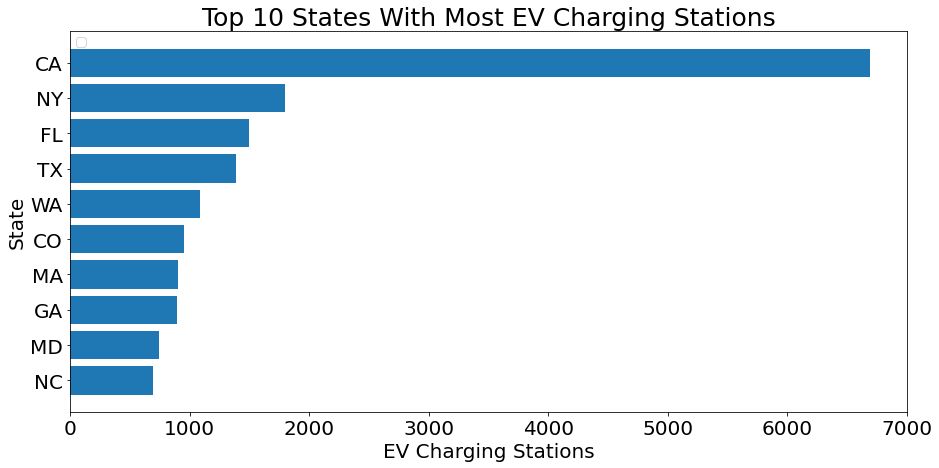

In [6]:
#Create Figure
fig, ax1 = plt.subplots(figsize=(15,7))

#Total station by state
tot_st = station_db['State'].value_counts().head(10)
ax1.barh(tot_st.index, tot_st.values)
ax1.set_xlabel('EV Charging Stations', size = 20)
ax1.set_ylabel('State', size = 20)
ax1.set_title('Top 10 States With Most EV Charging Stations', size = 25)
ax1.legend(loc=2, prop={'size': 12})
ax1.invert_yaxis()
ax1.set_xlim(0,7000)
ax1.tick_params(axis='both', which='major', labelsize=20)
#ax1.grid()

## 2. Top 2 EV Network Total Charging Ports

No handles with labels found to put in legend.
No handles with labels found to put in legend.


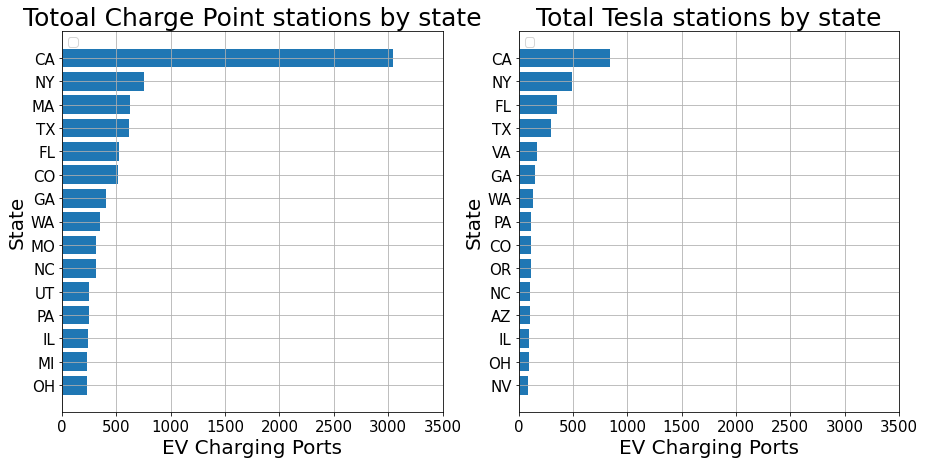

In [7]:
#Create two subplots
fig, ax = plt.subplots(1, 2, figsize=(15,7), sharex=True, sharey=False)

#Charge Point station by state
chpt_st = station_db[station_db['EV Network']=='ChargePoint Network']['State'].value_counts().head(15)
ax[0].barh(chpt_st.index, chpt_st.values)
ax[0].set_xlabel('EV Charging Ports', size = 20)
ax[0].set_ylabel('State', size = 20)
ax[0].set_title('Totoal Charge Point stations by state', size = 25)
ax[0].legend(loc=2, prop={'size': 12})
ax[0].invert_yaxis()
ax[0].set_xlim(0,3500)
ax[0].grid()
ax[0].tick_params(axis='both', which='major', labelsize=15)

#Tesla station by state
tsla_st = station_db[station_db['EV Network']=='Tesla']['State'].value_counts().head(15)
ax[1].barh(tsla_st.index, tsla_st.values)
ax[1].set_xlabel('EV Charging Ports', size = 20)
ax[1].set_ylabel('State', size = 20)
ax[1].set_title('Total Tesla stations by state', size = 25)
ax[1].legend(loc=2, prop={'size': 12})
ax[1].invert_yaxis()
ax[1].set_xlim(0,3500)
ax[1].grid()
ax[1].tick_params(axis='both', which='major', labelsize=15)

## 3. Top EV Networks by Total Charging Ports

(0.0, 40000.0)

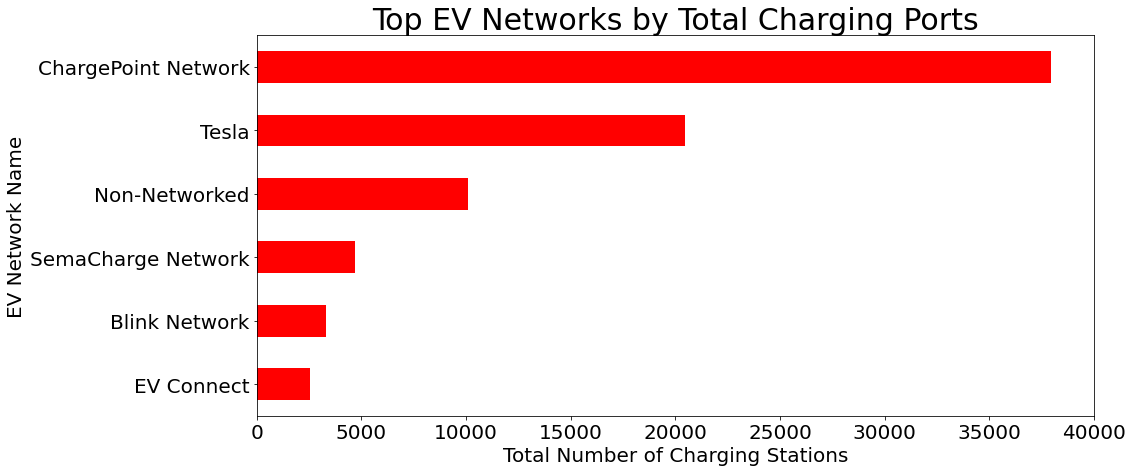

In [8]:
#Plotting total charging ports by EV Network
charge_ports = station_db.groupby('EV Network')['EV Level2 EVSE Num'].sum().sort_values(ascending = False) + station_db.groupby('EV Network')['EV DC Fast Count'].sum().sort_values(ascending = False)
fig, ax = plt.subplots(figsize=(15,7))
charge_ports.sort_values(ascending = False)[0:6].plot(kind='barh', color='r')
plt.xlabel('Total Number of Charging Stations', size = 20)
plt.ylabel('EV Network Name', size = 20)
plt.title('Top EV Networks by Total Charging Ports', size = 30)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.gca().invert_yaxis()
plt.xlim(0,40000)

## 4. Top EV Networks for Level 2/Level 3 Total Charging Ports

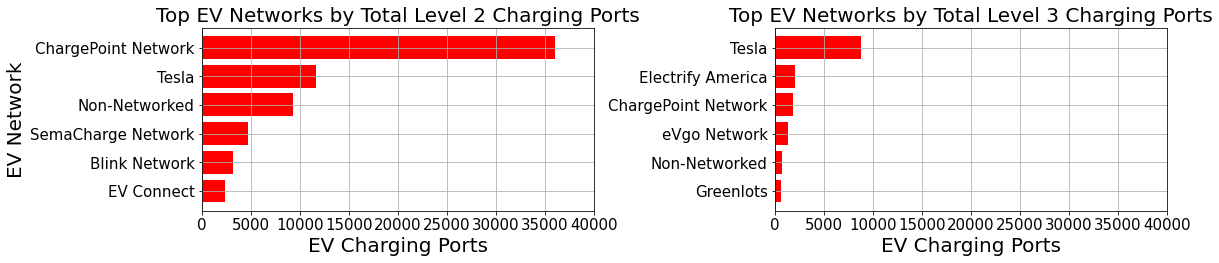

In [9]:
#Create two subplots
fig, ax = plt.subplots(1, 2, figsize=(18,7), sharex=True, sharey=False)
fig.tight_layout(pad=15.0)

#Top 5 total charging stations by EV Network
charge_ports2 = station_db.groupby('EV Network')['EV Level2 EVSE Num'].sum().sort_values(ascending = False)[0:6]

ax[0].barh(charge_ports2.index, charge_ports2.values, color='r')
ax[0].set_xlabel('EV Charging Ports', size = 20)
ax[0].set_ylabel('EV Network', size = 20)
ax[0].set_title('Top EV Networks by Total Level 2 Charging Ports', size = 20)
ax[0].invert_yaxis()
ax[0].set_xlim(0, 40000)
ax[0].grid()
ax[0].tick_params(axis='both', which='major', labelsize=15)

#Tesla station by state
charge_ports3 = station_db.groupby('EV Network')['EV DC Fast Count'].sum().sort_values(ascending = False)[0:6]

ax[1].barh(charge_ports3.index, charge_ports3.values, color='r')
ax[1].set_xlabel('EV Charging Ports', size = 20)
ax[1].set_title('Top EV Networks by Total Level 3 Charging Ports', size = 20)
ax[1].invert_yaxis()
ax[1].set_xlim(0,40000)
ax[1].grid()
ax[1].tick_params(axis='both', which='major', labelsize=15)

## 5. Top EV Networks by Total Charging Stations

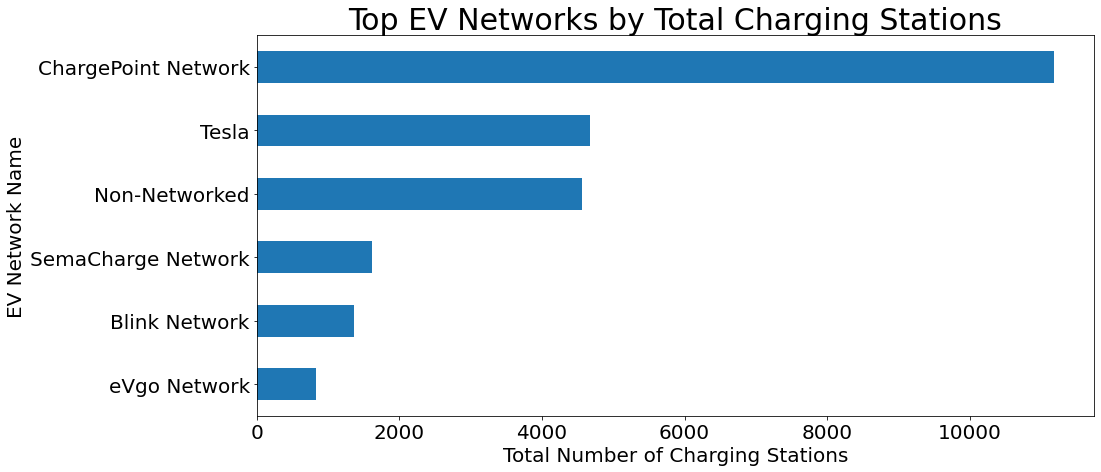

In [10]:
#Top 5 total charging stations by EV Network
fig, ax = plt.subplots(figsize=(15,7))
station_db['EV Network'].value_counts()[0:6].plot(kind='barh')
plt.xlabel('Total Number of Charging Stations', size = 20)
plt.ylabel('EV Network Name', size = 20)
plt.title('Top EV Networks by Total Charging Stations', size = 30)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.gca().invert_yaxis()

## 6. Top EV Charging Station Locations

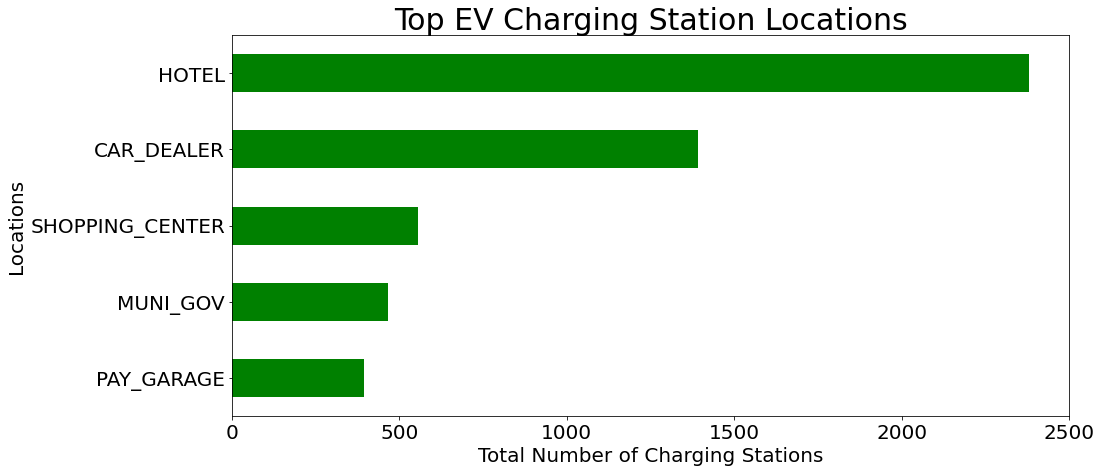

In [11]:
#Top 5 locations where charging stations are located by total number
fig, ax = plt.subplots(figsize=(15,7))
station_db['Facility Type'].value_counts()[0:5].plot(kind='barh', color='g')
plt.xlabel('Total Number of Charging Stations', size = 20)
plt.ylabel('Locations', size = 20)
plt.title('Top EV Charging Station Locations', size = 30)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.gca().invert_yaxis()

## 7. Top EV Charging Stations Located at Hotels

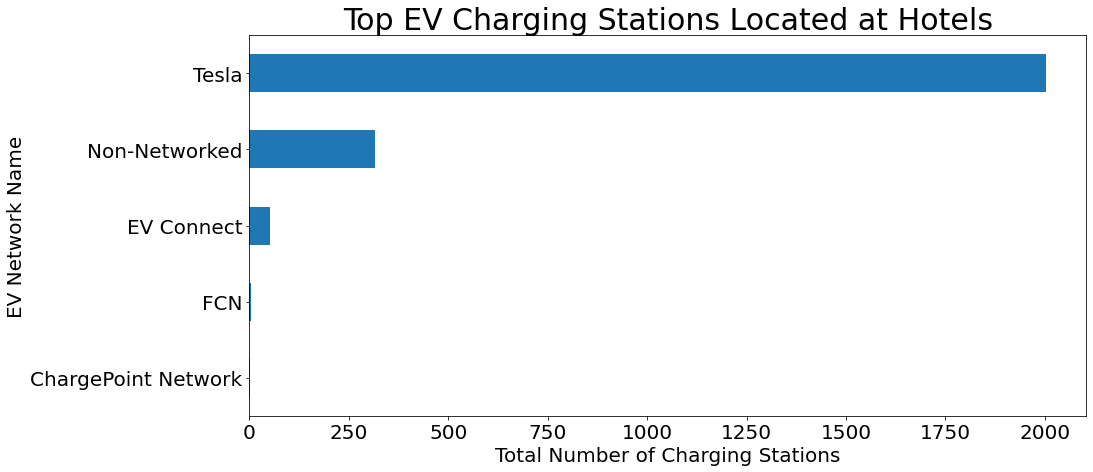

In [12]:
#Top EV Networks located at a hotel
fig, ax = plt.subplots(figsize=(15,7))
station_db[station_db['Facility Type']=='HOTEL']['EV Network'].value_counts()[0:5].plot(kind='barh')
plt.xlabel('Total Number of Charging Stations', size = 20)
plt.ylabel('EV Network Name', size = 20)
plt.title('Top EV Charging Stations Located at Hotels', size = 30)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.gca().invert_yaxis()

___________________________________________________________
# Extract Ratings Data from API and Import/Export to/from MongoDB
___________________________________________________________

In [13]:
#EV Networks located in a hotel parking lot
station_db_hotel = station_db[station_db['Facility Type']=='HOTEL'].iloc[:, [7,11,14,15]]

#Observe the data needed to use the Google API
#station_db_hotel.info()

In [14]:
#Define API Client to interact with Google 
#gmaps = googlemaps.Client(key='Key Here')

#Connect to MongoDB container on Docker 
myclient = MongoClient('localhost', 27017)

#Create database variable from Mongo DB
mongo_hotels_database = myclient.db_hotels

#Create collection variable from Mongo DB
mongo_hotels_collection = mongo_hotels_database.collection_hotels

#Results counter
rslts_cntr = 0

#Loop through 2000 random rows and feed the data into Google API
for index, row in station_db_hotel.sample(2000).iterrows():

    #Clear counter
    clear_output(wait=True)
    
    #Search Google API for 'Place ID'
    hotel_id = gmaps.find_place(input = row.full_address, input_type = 'textquery')
    
    #Create variable for the place_id
    try:
        id_num = hotel_id['candidates'][0]['place_id']
    except IndexError:
        id_num = 'null'
    #Use 'Place ID' to find further details of hotel
    if id_num == 'null':
        pass
    else:
        hotel_details = gmaps.place(place_id = id_num)
    
    #Load data into MongoDB
    if id_num == 'null':
        pass
    else:
        if not mongo_hotels_collection.find_one(hotel_details['result']):
            mongo_hotels_collection.insert_one(hotel_details['result'])
    
    #Iterate Counter
    rslts_cntr += 1
    
    #Print current progress
    print("Currently collecting data on row: {}".format(rslts_cntr))
    
    #Print each input as it is created
    #pprint.pprint(hotel_details)
    
print("Finished Collecting Data")

In [15]:
#Create Pandas Data Frame from the Cities Collection
pd_hotels_db = pd.DataFrame(list(mongo_hotels_collection.find()))

#View the Hotel Collection
#pd_hotels_db.info()

In [16]:
#Remove unnecessary columns
pd_hotels_db_useful = pd_hotels_db.iloc[:, [9,14]]
#19
#Observe the useful data
pd_hotels_db_useful.sample(10)

,name,rating
344,Hobuck Beach Resort,4.6
1551,Marriott Irvine Spectrum,4.5
540,Horseshoe Bay Resort,4.3
1258,The Mill Casino • Hotel & RV Park,4.1
319,Hampton Inn & Suites Blythe,4.5
1006,250 Main Hotel,4.7
531,Hilton Garden Inn Tifton,4.4
1744,Holiday Inn Express & Suites Decatur,4.4
649,Red Rock Casino Resort and Spa,4.5
544,"The Golden Hotel, Ascend Hotel Collection",4.5


_________________________________________________________________
# Import/Export 'Top 1000 US Cities' json Data in MongoDB
________________________________________________________________

In [17]:
#Cities.json file loaded into MongoDB using the following command in the terminal
#mongoimport --db db_cities --collection collection_cities < cities.json --jsonArray

In [18]:
#Create database variable from Mongo DB
mongo_cities_database = myclient.db_cities

#Create collection variable from Mongo DB
mongo_cities_collection = mongo_cities_database.collection_cities

#Create Pandas Data Frame from the Cities Collection
pd_cities_db = pd.DataFrame(list(mongo_cities_collection.find()))

In [19]:
#Convert Lat-Long data into a readable format for Google API
pd_cities_db['latitude'] = pd_cities_db['latitude'].astype(str)
pd_cities_db['longitude'] = pd_cities_db['longitude'].astype(str) 
pd_cities_db['lat_long'] = pd_cities_db['latitude'] + ',' + pd_cities_db['longitude']

In [20]:
#Review data
#pd_cities_db.info()

In [21]:
#Remove unnecessary columns
pd_cities_db = pd_cities_db.iloc[:,[1,7,8]]

#See sample of the data
pd_cities_db.sample(5)

,city,state,lat_long
454,Wyoming,Michigan,"42.9133602,-85.7053085"
911,Carol Stream,Illinois,"41.91252859999999,-88.13479269999999"
852,Coachella,California,"33.6803003,-116.173894"
772,Alexandria,Louisiana,"31.3112936,-92.4451371"
637,Midwest City,Oklahoma,"35.4495065,-97.3967019"


_____________________________________________________
# Extract Random Hotel Data from Google Maps API
______________________________________________________

In [22]:
#Create Mongo Database for random hotel results
gmaps_ev_hotel_db = myclient["gmaps_ev_hotel_db"] 

#Create Mongo Collection for random hotel results 
gmaps_ev_hotel_cl = gmaps_ev_hotel_db["gmaps_ev_hotel_cl"] 

#Results counter
rslts_cntr = 0

#Loop through each row and feed the data into Google API
for index, row in pd_cities_db.head(1000).iterrows():

    #Clear counter
    clear_output(wait=True)
        
    #Randomly choose between the 
        
    #Randomly generate a range for Google API to look for a hotel 
    random_distance = random.randrange(500, 20000)
    
    #Define the input for location_bias input for Google API
    city_location = 'circle:' + str(random_distance) + '@' + str(row.lat_long)
   
    #Create variable for output data from Google API
    random_hotel = gmaps.find_place(input = 'hotel', input_type = 'textquery', 
                                    fields = ['name', 'rating', 'user_ratings_total'],
                                    location_bias = city_location)
     
    #Load data into MongoDB
    if not gmaps_ev_hotel_cl.find_one(random_hotel['candidates'][0]):
        gmaps_ev_hotel_cl.insert_one(random_hotel['candidates'][0])
    
    #Iterate Counter
    rslts_cntr += 1
    
    #Print current progress
    print("Currently collecting data on row: {}".format(rslts_cntr))
    
    #Print each result as it is created
    #print(random_hotel['candidates'][0])
    
print("Finished Collecting Data")

In [23]:
#Create Pandas Data Frame from the Mongo Database
pd_hotels_random = pd.DataFrame(list(gmaps_ev_hotel_cl.find()))

#Remove unneeded columns
pd_hotels_random = pd_hotels_random.iloc[:, [1,2]]

#Observe some of the useful dataframe 
#pd_hotels_random.sample(10)
pd_hotels_random.sample(10)

,name,rating
630,Hilton Garden Inn Hickory,4.5
616,Tru by Hilton Sumter,4.4
197,Hyatt Place Athens / Downtown,4.5
17,Omni Fort Worth Hotel,4.4
242,Hotel Encanto de Las Cruces,4.2
354,Golden Nugget Lake Charles Hotel & Casino,4.4
258,McMenamins Grand Lodge,4.4
324,Holiday Inn Express & Suites Chowchilla - Yose...,4.2
9,Hilton Garden Inn Indianapolis Downtown,4.4
337,"Club Quarters Hotel, Philadelphia, Rittenhouse...",4.0


__________________________________________________________
# Hypothesis Testing on Hotel Ratings 
__________________________________________________________

### EV Hotel Data

In [24]:
#Create variable for the mean of the EV hotel data
ev_mean = pd_hotels_db_useful.describe().loc[['mean']].iloc[0,0]

#Create variable for the standard deviation of the EV hotel data
ev_std = pd_hotels_db_useful.describe().loc[['std']].iloc[0,0]

#Create variable for the total count of the EV hotel data
ev_count = pd_hotels_db_useful.describe().loc[['count']].iloc[0,0]

#Create variable for the standard error of the EV hotel data
ev_std_err = ev_std/np.sqrt(ev_count)

#Show summary of stats about the EV hotel data
pd_hotels_db_useful.describe()

,rating
count,1882.000000
mean,4.369660
std,0.304003
min,1.500000
25%,4.200000
50%,4.400000
75%,4.600000
max,5.000000


### Random Hotel Data

In [25]:
#Create variable for the mean of the random hotel data
random_mean = pd_hotels_random.describe().loc[['mean']].iloc[0,0]

#Create variable for the standard deviation of the random hotel data
random_std = pd_hotels_random.describe().loc[['std']].iloc[0,0]

#Create variable for the total count of the random hotel data
random_count = pd_hotels_random.describe().loc[['count']].iloc[0,0]

#Create variable for the standard error of the random hotel data
random_std_err = random_std/np.sqrt(random_count)

#Show summary of stats about the random hotel data
pd_hotels_random.describe()

,rating
count,671.000000
mean,4.346796
std,0.277114
min,2.300000
25%,4.200000
50%,4.400000
75%,4.500000
max,5.000000


### Calculating P-Value

In [26]:
#Turn ratings column into numpy array for both data sets
ev_ary = pd_hotels_db_useful['rating'].dropna().to_numpy()
random_ary = pd_hotels_random['rating'].dropna().to_numpy()

#We cannot assume the variance of the two samples will be the same so we use a Welch T-Test
t,p = stats.ttest_ind(random_ary, ev_ary, equal_var = False)
print(t)
#t-value, p-value, dof
print("Calculated Two Tailed P-Value: {}".format(p))

-1.7878407834968162
Calculated Two Tailed P-Value: 0.07403743166503038


### Visualizing Results

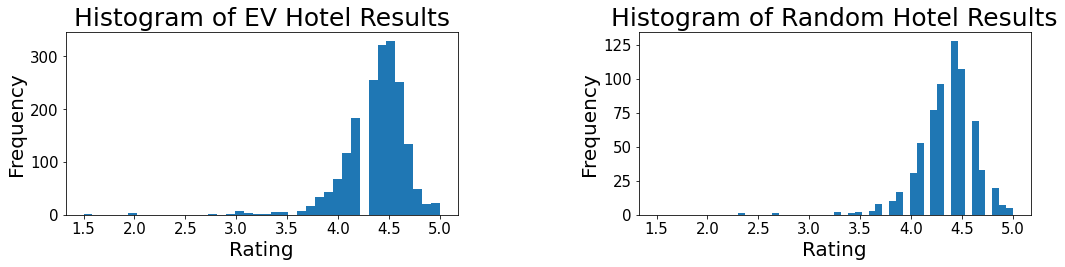

In [27]:
#Create two subplots
fig, ax = plt.subplots(1, 2, figsize=(18,7), sharex=True, sharey=False)
fig.tight_layout(pad=15.0)
bins_num = 40

ax[0].hist(pd_hotels_db_useful['rating'], bins = bins_num)
ax[1].hist(pd_hotels_random['rating'], bins = bins_num)

ax[0].set_xlabel('Rating', size = 20)
ax[0].set_ylabel('Frequency', size = 20)
ax[0].set_title('Histogram of EV Hotel Results', size = 25)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].set_xlabel('Rating', size = 20)
ax[1].set_ylabel('Frequency', size = 20)
ax[1].set_title('Histogram of Random Hotel Results', size = 25)
ax[1].tick_params(axis='both', which='major', labelsize=15)

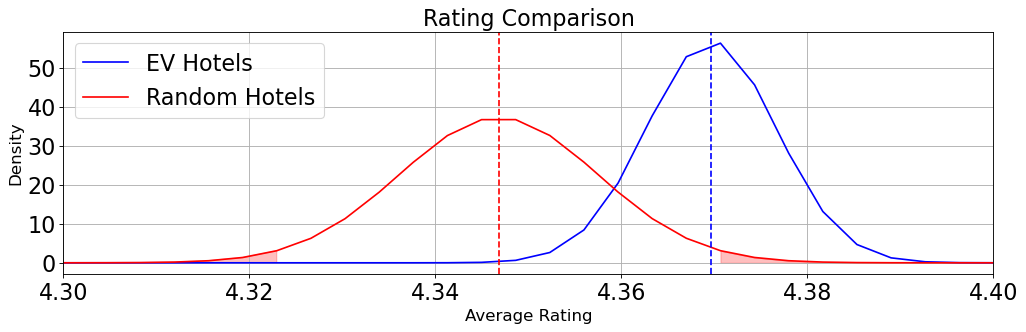

In [28]:
#Listing the various results from the data
x = np.linspace(4,4.4,110)
ev_pdf = stats.norm.pdf(x, ev_mean, ev_std_err) # the normal pdf for EV data
random_pdf = stats.norm.pdf(x, random_mean, random_std_err) # the normal pdf for random data

#Plot the two normal distributions 
plt.figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x, ev_pdf, label='EV Hotels', color = 'b')
plt.plot(x, random_pdf, label='Random Hotels', color = 'r')
plt.xlabel('Average Rating', size = 15)
plt.ylabel('Density', size = 15)
plt.title('Rating Comparison', size = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlim(4.3, 4.4)
plt.grid()
plt.legend(fontsize=20)

#Visually show the mean for both distributions
plt.axvline(ev_mean, ymax=4, linestyle="--", color='b')
plt.axvline(random_mean, ymax=4, linestyle="--", color='r')

#Visually show the Alpha values in red
plt.fill_between(x, random_pdf, where=(x >= random_mean+random_std_err*1.96), color="r", alpha=0.25)
plt.fill_between(x, random_pdf, where=(x <= random_mean-random_std_err*1.96), color="r", alpha=0.25)

plt.show()

In [31]:
#Export data to CSV
pd_hotels_db_useful.dropna().to_csv('CSV_Files/ev_hotels.csv')
pd_hotels_random.dropna().to_csv('CSV_Files/random_hotels.csv')